In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

In [22]:
def ultimate_split(yb, input_data, ids):
    """
    The ultimate split. THE real BADA$$.
    """
    
    mask_0 = (input_data[:,22] == 0)
    mask_1 = (input_data[:,22] == 1)
    mask_2 = (input_data[:,22] == 2)
    mask_3 = (input_data[:,22] == 3)
    
    return yb[mask_0], yb[mask_1], yb[mask_2], yb[mask_3], \
input_data[mask_0], input_data[mask_1], input_data[mask_2], input_data[mask_3], \
ids[mask_0], ids[mask_1], ids[mask_2], ids[mask_3]

In [23]:
def remove_features_0(input_data_0):
    """
    Remove the useless features if the jet num feature is equal to 0
    """
    useless_features_index = [4, 5, 6, 12, 23, 24, 25 , 26, 27, 28, 30, 33]
    
    mask = np.ones(int(input_data_0.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return input_data_0[:,mask]

def remove_features_1(input_data_1):
    """
    Remove the useless features if the jet num feature is equal to 1
    """
    useless_features_index = [4, 5, 6, 26, 27, 28, 30, 33]
    
    mask = np.ones(int(input_data_1.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return input_data_1[:,mask]

    # No need for jet_num equal to 2 or 3 : all the features are kept    
    

In [24]:
def angle_features_processing(data_path):
    """
    We want to change all the features representing an angle into two features
    one for cosinus of the angle and another for sinus of the angle.
    """
    
    yb, input_data, ids = load_csv_data(data_path,sub_sample = False)

    angle_features = [15, 18, 20, 25, 28]
    
    new_data = np.zeros((input_data.shape[0], input_data.shape[1] + len(angle_features) ))
    
    for k in range(input_data.shape[1]):
        if k not in angle_features:
            new_data[:, k] = input_data[:, k]
        
    for idx, column in enumerate(angle_features): 
        
        new_data[:, column] = np.cos(input_data[:, column])
        new_data[:, input_data.shape[1] + idx] = np.sin(input_data[:, column])
    
    return yb, new_data, ids

In [25]:
yb, input_data, ids =  angle_features_processing("train.csv")

yb0, yb1, yb2, yb3, data0, data1, data2, data3, ids0, ids1, ids2, ids3 = ultimate_split(yb, input_data, ids)

data0 = remove_features_0(data0)
data1 = remove_features_1(data1)

In [16]:
def jet_num_split_alt(yb, input_data, ids):
    """ jet_num is feature number 22 (starting counting at 0)
    returns 1) the data with jet_num <= 1 and 2) the data with jet_num >1
    4 5 6 23 24 25 26 27"""
    bool_mask = (input_data[:,22]<=1)

    return yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]

def remove_useless_features_alt(input_data_jetnum_inf1):
    useless_features_index = [4,5,6,23,24,25,26,27,28, 30, 33]
    mask = np.ones(int(input_data_jetnum_inf1.shape[1]), dtype=bool)
    # print(mask.shape)
    mask[(useless_features_index)] = False
    return input_data_jetnum_inf1[:,mask]

In [48]:
def jet_num_split(data_path, sub_sample = False):
    """ jet_num is feature number 22 (starting counting at 0)
        returns 1) the data with jet_num <= 1 and 2) the data with jet_num >1
        4 5 6 23 24 25 26 27"""
    yb, input_data, ids = load_csv_data(data_path,sub_sample = False)
    bool_mask = (input_data[:,22]<=1)

    return yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]

def remove_useless_features(input_data_jetnum_inf1):
    useless_features_index = [4,5,6,23,24,25,26,27,28]
    mask = np.ones(int(input_data_jetnum_inf1.shape[1]), dtype=bool)
    # print(mask.shape)
    mask[(useless_features_index)] = False
    return input_data_jetnum_inf1[:,mask]

In [18]:
yb, input_data, ids =  angle_features_processing("train.csv")

yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1 = jet_num_split_alt(yb, input_data, ids)

input_data_inf1 = remove_useless_features_alt(input_data_inf1)

In [49]:
yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1 = jet_num_split("train.csv", sub_sample = False)
input_data_inf1 = remove_useless_features(input_data_inf1)

In [19]:
print(input_data_inf1.shape)
print(input_data_sup1.shape)

(177457, 24)
(72543, 35)


In [6]:
"""sépare les données en 80/20 pour test et train
   retourne les données de train (3) puis les données de test (3)"""
def data_spliting(yb, input_data, ids):

    n = int(yb.shape[0])
    yb_test, input_data_test, ids_test = yb[:50000:], input_data[:50000:], ids[:50000:]
    yb_train, input_data_train, ids_train = yb[50000::], input_data[50000::], ids[50000::]
    return yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test


In [33]:
def ridge(yb_test, input_data_test, yb_train, input_data_train,lambda_):
    w, train_loss = ridge_regression(yb_train, input_data_train, lambda_)
    # w, train_loss = least_squares_GD(yb_train, input_data_train, np.random.rand(int(input_data_train.shape[1])), 50, 0.0001,computeLoss = True);
    
    # print(input_data_test.shape)
    #print(w.shape)
    
    test_loss = compute_loss(yb_test, input_data_test, w)
    y_pred = predict_labels(w, input_data_test)
    return w, train_loss, test_loss, y_pred


In [8]:
""" Générateur renvoyant (en k fois) des données splitées pour train et test
    Retourne les données de train puis de test"""
def K_split_LS(yb,input_data,ids,k):
    n = int(yb.shape[0])
    bool_mask = np.ones(n,dtype=bool)
    bool_mask[::k] = 0
    """On renvoie ... train puis ... test"""
    for i in range(k):
        yield yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]
        bool_mask[i::k] = 1
        bool_mask[i+1::k] = 0

In [9]:
def Kfold_ridge(k,degree,lambda_):

    train_loss_list = []
    test_loss_list = []
    score_list = []
    for yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test in K_split_LS(yb_sup1, input_data_sup1, ids_sup1,k):
        input_data_train_poly = build_poly(input_data_train,degree)
        input_data_test_poly = build_poly(input_data_test,degree)
        w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test_poly, yb_train, input_data_train_poly,lambda_)
        train_loss_list+=[train_loss]
        test_loss_list+=[test_loss]
        score_list+=[np.mean(y_pred == yb_test)]
        
    return train_loss_list, test_loss_list,score_list  

In [10]:
def CrossVal_ridge(k,degree,lambda_):

    yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test = data_spliting(yb, input_data, ids)
    
    input_data_train_poly = build_poly(input_data_train,degree)
    input_data_test_poly = build_poly(input_data_test,degree)
    
    w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test_poly, yb_train, input_data_train_poly,lambda_)

        
    return [train_loss], [test_loss], [np.mean(y_pred == yb_test)]

In [11]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

Degree 2 done
Degree 3 done
Degree 4 done
Degree 5 done
Degree 6 done
Degree 7 done
Degree 8 done
Degree 9 done
Degree 10 done
Degree 11 done
Degree 12 done


No handles with labels found to put in legend.


Degree 13 done


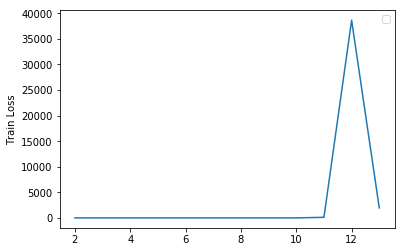

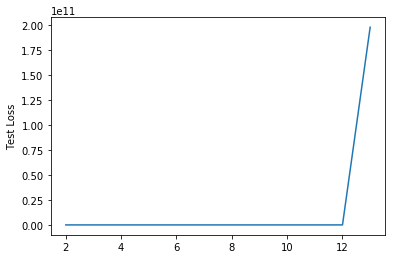

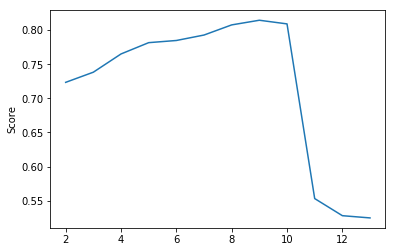

([0.3687723264979983,
  0.3559970595771841,
  0.33436656220890837,
  0.31750210693116393,
  0.3136843279135199,
  0.30679021801233797,
  0.29272867603172653,
  0.28724608844628186,
  0.2900164371430373,
  121.58654533005529,
  38644.93563693909,
  1950.72043230404],
 [0.36957004094058643,
  0.35901385781348816,
  0.34886843037772153,
  0.42983595627093524,
  0.8243598860751964,
  2.6468518543553934,
  21.495845477495443,
  123.47038968320696,
  5337.463315221049,
  301025.4060306861,
  10139792.234867264,
  197670444239.98264],
 [0.723377876356912,
  0.7382380176853399,
  0.7649394226660183,
  0.7814813092023469,
  0.7846517855497203,
  0.7926332580688864,
  0.8074795834974576,
  0.8142894065243501,
  0.8089407379412048,
  0.553244087674625,
  0.5281977917741906,
  0.5249301974983931])

In [12]:
def param_test(k,max_deg,max_lambda,lambda_step):
    lambda_list = np.arange(0,max_lambda,lambda_step)
    #lambda_list = np.logspace(1, 5, num=6)
    degree_list = np.arange(2,max_deg)
    final_train_loss_list = []
    final_test_loss_list = []
    final_score_list = []
    
    lambda_ = 10
    
    for degree in degree_list:
        train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
        #train_loss_list, test_loss_list,score_list = CrossVal_ridge(k,degree,lambda_)
        train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
        final_train_loss_list+=[train_loss]
        final_test_loss_list+=[test_loss]
        final_score_list+=[score]
        print("Degree " + str(degree) + " done")
    """
    degree = 4
    for lambda_ in lambda_list:
        train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
        train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
        final_train_loss_list+=[train_loss*(1./degree)]
        final_test_loss_list+=[test_loss*(1./degree)]
        final_score_list+=[score]
        print("Lambda =  " + str(lambda_) + " done")
    """
    plt.legend()
    plt.figure(1)  
    plt.plot(degree_list,final_train_loss_list)
    plt.ylabel("Train Loss")
    plt.figure(2)
    plt.plot(degree_list,final_test_loss_list)
    plt.ylabel("Test Loss")
    plt.figure(3)
    plt.plot(degree_list,final_score_list)
    plt.ylabel("Score")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list


def param_test_simultane(k,max_deg,max_lambda,number_lambda):
    lambda_list = np.linspace(10,max_lambda,number_lambda)
    #lambda_list = np.logspace(1, 5, num=5)
    degree_list = np.arange(2,max_deg+1)
    
    final_train_loss_list = np.zeros((len(degree_list),number_lambda))
    final_test_loss_list = np.zeros((len(degree_list),number_lambda))
    final_score_list = np.zeros((len(degree_list),number_lambda))
    """
    final_train_loss_list = np.zeros((len(degree_list),5))
    final_test_loss_list = np.zeros((len(degree_list),5))
    final_score_list = np.zeros((len(degree_list),5))
    """
    
    for j,degree in enumerate(degree_list):
        for i, lambda_ in enumerate(lambda_list):
            train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
            #train_loss_list, test_loss_list,score_list = CrossVal_ridge(k,degree,lambda_)
            train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
            final_train_loss_list[j,i]=train_loss
            final_test_loss_list[j,i]=test_loss
            final_score_list[j,i]=score
            print ("Degree = " + str(degree) + " and Lambda = " + str(lambda_))
    
    
    plt.legend()
    plt.figure(1)
    #plt.contourf(lambda_list,degree_list, final_train_loss_list, 20, cmap='RdGy')
    plt.pcolor(lambda_list,degree_list, final_train_loss_list)
    #plt.colorbar();
    plt.ylabel("Train Loss")
    plt.figure(2)
    plt.contourf(lambda_list,degree_list,  final_test_loss_list, 20, cmap='RdGy')
    plt.colorbar();
    plt.ylabel("Test Loss")
    plt.figure(3)
    plt.contourf(lambda_list,degree_list,  final_score_list, 20, cmap='RdGy')
    plt.colorbar();
    plt.ylabel("Score")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list

param_test(10,14,80,10)


In [20]:
def submission_ridge(degree_inf1,degree_sup1,lambda_inf1,lambda_sup1):
    
    #For the inf1 data
    # yb_inf1_test, input_data_inf1_test, ids_inf1_test, yb_sup1_test, input_data_sup1_test, ids_sup1_test = jet_num_split("test.csv")
    yb_t, input_data_t, ids_t =  angle_features_processing("test.csv")

    yb_inf1_test, input_data_inf1_test, ids_inf1_test, yb_sup1_test, input_data_sup1_test, ids_sup1_test = jet_num_split_alt(yb_t, input_data_t, ids_t)

    input_data_inf1_test = remove_useless_features_alt(input_data_inf1_test)
    
    
    input_data_inf1_test_poly = build_poly(input_data_inf1_test, degree_inf1)
    input_data_inf1_poly = build_poly(input_data_inf1,degree_inf1)
    w, train_loss, test_loss, y_pred_inf1 = ridge(yb_inf1_test, input_data_inf1_test_poly, yb_inf1, input_data_inf1_poly,lambda_inf1)
    
    #For the sup1 data
    input_data_sup1_test_poly = build_poly(input_data_sup1_test, degree_sup1)
    input_data_sup1_poly = build_poly(input_data_sup1,degree_sup1)
    w, train_loss, test_loss, y_pred_sup1 = ridge(yb_sup1_test, input_data_sup1_test_poly, yb_sup1, input_data_sup1_poly,lambda_sup1)
    
    final_ids_test = np.concatenate((ids_inf1_test,ids_sup1_test))
    final_y_pred = np.concatenate((y_pred_inf1,y_pred_sup1))
    create_csv_submission(final_ids_test, final_y_pred, "pred_4_210.csv")
    
submission_ridge(8,10,150,120)    

In [34]:
def submission_ridge_4split(deg0, deg1, deg2, deg3,lambda0, lambda1, lambda2, lambda3):
    
    #For the jet_num 0 data
    yb_t, input_data_t, ids_t =  angle_features_processing("test.csv")

    yb0t, yb1t, yb2t, yb3t, data0t, data1t, data2t, data3t, ids0t, ids1t, ids2t, ids3t = ultimate_split(yb_t, input_data_t, ids_t)

    data0t = remove_features_0(data0t)
    data1t = remove_features_1(data1t)
    
        
    poly_test0 = build_poly(data0t, deg0)

    poly0 = build_poly(data0,deg0)
    w, train_loss, test_loss, y_pred0 = ridge(yb0t, poly_test0, yb0, poly0,lambda0)
    
    #For the jet_num 1 data
    poly_test1 = build_poly(data1t, deg1)
    poly1 = build_poly(data1,deg1)
    w, train_loss, test_loss, y_pred1 = ridge(yb1t, poly_test1, yb1, poly1,lambda1)
    
    #For the jet_num 2 data
    poly_test2 = build_poly(data2t, deg2)
    poly2 = build_poly(data2,deg2)
    w, train_loss, test_loss, y_pred2 = ridge(yb2t, poly_test2, yb2, poly2,lambda2)

    #For the jet_num 3 data
    poly_test3 = build_poly(data3t, deg3)
    poly3 = build_poly(data3,deg3)
    w, train_loss, test_loss, y_pred3 = ridge(yb3t, poly_test3, yb3, poly3,lambda3)

    
    
    final_ids_test = np.concatenate((ids0t, ids1t, ids2t, ids3t))
    final_y_pred = np.concatenate((y_pred0,y_pred1,y_pred2,y_pred3))
    create_csv_submission(final_ids_test, final_y_pred, "pred_4split.csv")
    
submission_ridge_4split(9,9,9,9,150,150,120,120)    

In [31]:
"""yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1"""
w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test, yb, input_data,0)
print (w, train_loss, test_loss)

NameError: name 'yb_test' is not defined